# Validate proseco star and fid selection for 2018 obsids

This is a notebook to do validation of the acquisition and guide stars and the fids
that are selected by proseco.  The sample is all obsids with a star catalog between 2018:001 and 2018:250.

The focus here is on acquisition star quality compared to the as-run flight catalogs.  These come from the original SAUSAGE-selected catalogs but in most of the worst cases include hand-edits suggested by ACA reviewers.

This notebook also provides information about performance and the distribution of run time to select a catalog.

In [117]:
from pathlib import Path
import sys
import os
from pprint import pprint
sys.path.insert(0, str(Path(os.environ['HOME'], 'git', 'mica')))
sys.path.insert(0, str(Path(os.environ['HOME'], 'git', 'proseco')))

from astropy.table import Table

from kadi.commands.states import get_states
from mica.starcheck import get_starcheck_catalog
from proseco import get_aca_catalog
from proseco.catalog import ACATable
from proseco.core import ACACatalogTable
from proseco.report import make_report
from chandra_aca.star_probs import acq_success_prob, prob_n_acq
import proseco
import agasc
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
version = proseco.test(get_version=True)
print(version)

1.2.1-r364-5cf1de5


In [3]:
data_dir = Path('run_' + version)
data_dir.mkdir(exist_ok=True)

In [4]:
states = get_states(start='2018:001', stop='2018:250', state_keys=['obsid'])
obsids = states['obsid']

In [163]:
len(obsids)

1258

In [5]:
def process_obsid(obsid):
    dirpath = data_dir / f'obs{obsid:05}'
    if (dirpath / 'aca_cat.pkl').exists():
        return
    try:
        obs = get_starcheck_catalog(obsid)
        starcat = obs['cat']
        assert isinstance(starcat, Table)
    except:
        # print(f'\nObsid {obsid} has no starcheck catalog')
        return
    
    probs = [p_acq for p_acq in starcat['p_acq']
             if p_acq is not None]
    p_n_or_fewer = prob_n_acq(probs)[1]
    sausage_P2 = -np.log10(p_n_or_fewer[2])
    # print(obsid, sausage_P2)
    
    aca = get_aca_catalog(obsid)
    
    if aca.exception:
        print(f'\nObsid {obsid} failed')
        dirpath.mkdir(exist_ok=True)
        with open(dirpath / 'exception', 'w') as fh:
            fh.write(aca.exception)
    else:
        aca.to_pickle(data_dir)

In [7]:
for ii, obsid in enumerate(obsids):
    print('.', end='')
    if ii % 50 == 49:
        print()
    process_obsid(obsid)

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
...............................

In [164]:
def get_info(obsid, include_aca=False):
    aca = ACATable.from_pickle(obsid, rootdir=data_dir)
    out = {'obsid': obsid,
           'acq_thumb': aca.acqs.thumbs_up,
           'gui_thumb': aca.guides.thumbs_up,
           'fid_thumb': aca.fids.thumbs_up}
    
    rows = [(event['data'], event['dt']) for event in aca.log_info['events']]
    events = Table(rows=rows, names=['data', 'dt'])
    events.add_index('data')
    
    t0_acq = events.loc['Starting get_acq_catalog']['dt']
    t0_fid = events.loc['Starting get_fid_catalog']['dt']
    t0_opt = events.loc['Starting optimize_acqs_fids']['dt']
    t0_guide = events.loc['Starting get_guide_catalog']['dt']
    t0_merge = events.loc['Starting merge_cats']['dt']
    t_end = events.loc['Finished aca_get_catalog']['dt']
    
    out['t_acq'] = t0_fid - t0_acq
    out['t_fid'] = t0_opt - t0_fid
    out['t_opt'] = t0_guide - t0_opt
    out['t_guide'] = t0_merge - t0_guide
    out['t_merge'] = t_end - t0_merge
    out['t_total'] = t_end - t0_acq

    acqs = aca.acqs
    t_ccd = acqs.t_ccd
    date = acqs.date
    color = acqs['color']
    mag = acqs['mag']
    halfw = acqs['halfw']
    
    probs = [acq['probs'].p_acq_model(acq['halfw']) for acq in acqs]
    # probs = acq_success_prob(t_ccd=t_ccd, date=date, color=color, mag=mag,
    #                         halfwidth=halfw)
    _, p_n_or_fewer = prob_n_acq(probs)
    out['proseco_P2'] = -np.log10(p_n_or_fewer[2])
    out['thumbs_P2'] = -acqs.get_log_p_2_or_fewer()
    
    acq_hand_edit = False
    guide_hand_edit = False
    probs = []
    for acq in aca.starcheck_catalog['cat']:
        if acq['p_acq'] is None:
            continue
        if 'aX' in acq['pass']:
            acq_hand_edit = True
        if 'gX' in acq['pass']:
            guide_hand_edit = True
            
        halfw = acq['halfw']
        try:
            acq0 = acqs.cand_acqs.get_id(acq['id'])
            mag = acq0['mag']
            color = acq0['color']
        except KeyError:
            star = agasc.get_star(acq['id'])
            color = star['COLOR1']
            mag = star['MAG_ACA']

        prob = acq_success_prob(t_ccd=t_ccd, date=date, color=color, mag=mag,
                                halfwidth=halfw)
        probs.append(prob)


    _, p_n_or_fewer = prob_n_acq(probs)
    out['sausage_P2'] = -np.log10(p_n_or_fewer[2])
    out['acq_hand_edit'] = acq_hand_edit
    out['guide_hand_edit'] = guide_hand_edit
    
    if include_aca:
        out['aca'] = aca
    
    return out

In [165]:
rows = []
for ii, obsid in enumerate(obsids[1:]):
    if ii % 100 == 99:
        print(ii)
    if (data_dir / f'obs{obsid}' / 'aca_cat.pkl').exists():
        rows.append(get_info(obsid))

99
199
299
399
499
599
699
799
899
999
1099
1199


In [167]:
dat = Table(rows, names='obsid acq_thumb fid_thumb gui_thumb acq_hand_edit guide_hand_edit thumbs_P2 proseco_P2 '
            'sausage_P2 t_acq t_fid t_guide t_merge t_opt t_total'.split())
dat['thumbs_P2'].format = '.2f'
dat['proseco_P2'].format = '.2f'
dat['sausage_P2'].format = '.2f'
dat.sort('sausage_P2')

In [170]:
np.count_nonzero(dat['acq_hand_edit'] | dat['guide_hand_edit'])

51

## P2 metrics (e.g obsid 19409)

P2 => -log10(probability of 2 or fewer)

- `thumbs_P2`: P2 using `p_acq` marginalized over maneuver errors for proseco catalog
- `proseco_P2`: P2 using `p_acq_model` for proseco catalog
- `sausage_P2`: P2 using `p_acq_model` for flight (SAUSAGE) catalog (possibly w/ hand-edits)

`proseco_P2` and `sausage_P2` are an apples-to-apples comparison of the quality of catalog, IGNORING spoiler stars and imposter hot pixels.  This is essentially what current starcheck (pre-proseco) uses.

`thumbs_P2` is the same metric but using the full probability model that includes everything.  It is always <= `proseco_P2` because `p_acq_model` is always multiplied by values <= 1.  This is what proseco uses for the acq catalog `thumbs_up` flag.

Obsid 19409 provides an interesting cases where the marginalized probability
is substantially worse than the straight acq model probability.

In [76]:
obs = get_info(19409, include_aca=True)
acqs = obs['aca'].acqs

In [77]:
[f'{p:.3f}' for p in acqs['p_acq']]  # marginalized

['0.985', '0.674', '0.919', '0.876', '0.552', '0.512', '0.392', '0.260']

In [78]:
[f'{acq["probs"].p_acq_model(acq["halfw"]):.3f}' for acq in acqs]

['0.985', '0.955', '0.919', '0.876', '0.555', '0.580', '0.408', '0.295']

In [79]:
# Overly optimistic because it ignores spoilers
print(f'proseco_P2 = {obs["proseco_P2"]:.3f}')

proseco_P2 = 2.722


In [80]:
# The hard truth
print(f'thumbs_P2 = {obs["thumbs_P2"]:.3f}')

thumbs_P2 = 2.051


In [81]:
# But still better than SAUSAGE
print(f'sausage_P2 = {obs["sausage_P2"]:.3f}')

sausage_P2 = 1.427


## Acquisition star hand-edits: 34 in 2018:001 through 2018:250

In [82]:
pprint(', '.join(str(x) for x in dat['obsid'][dat['hand_edit']]))

('21001, 21135, 21007, 21136, 19757, 20603, 20351, 21074, 19670, 20655, 19441, '
 '20394, 21068, 20403, 19351, 20612, 20532, 20902, 19647, 19515, 21005, 19425, '
 '19669, 21069, 19676, 19650, 20707, 20896, 19683, 20266, 20987, 21077, 18303, '
 '20373')


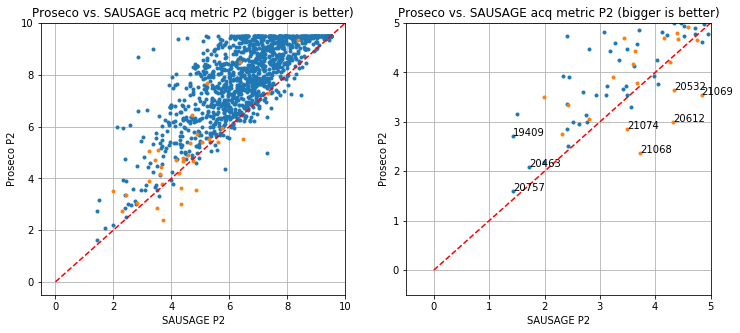

In [146]:
he = dat['acq_hand_edit']
def plot_sausage_vs_proseco(xylim, show_obsids=False):
    plt.plot(dat['sausage_P2'][~he], dat['proseco_P2'][~he], '.')
    plt.plot(dat['sausage_P2'][he], dat['proseco_P2'][he], '.')
    plt.plot([0, 10], [0, 10], '--r')
    plt.xlabel('SAUSAGE P2')
    plt.ylabel('Proseco P2')
    plt.xlim(None, xylim)
    plt.ylim(None, xylim)
    plt.grid();
    if show_obsids:
        bad = (dat['proseco_P2'] - dat['sausage_P2'] < -0.5) & (dat['sausage_P2'] < xylim)
        bad |= (dat['acq_thumb'] == 0)
        for obs in dat[bad]:
            plt.text(x=obs['sausage_P2'], y=obs['proseco_P2'], s=str(obs['obsid']))
    plt.title('Proseco vs. SAUSAGE acq metric P2 (bigger is better)')

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plot_sausage_vs_proseco(10)
plt.subplot(1, 2, 2)
plot_sausage_vs_proseco(5, show_obsids=True)


In the right plot, the 5 orange marked obsids show cases of relatively poor catalogs where proseco
chose something worse than the flight catalog.  These were all hand-edits.  These are actually
just two targets however:

- 21068, 20612, 21069: proseco did not choose a star with ASPQ1 with a close (7.5 arcsec) spoiler
- 21074, 20532: proseco did not choose a star with a bright nearby hot pixel (6400 e-/sec)

The other marked cases have a thumbs down for acq from proseco.

- 20757 - worse case, details below.
- 20463 - proseco does not choose B-V=0.7 stars at all.  Consider changing this as last-ditch option?
- 19409 - star 189400544 mag changed from 9.9 to 10.4 in AGASC 1.7, not used in proseco.  Actual was 10.4!

Details below

## Thumbs-down

In [84]:
dat[dat['acq_thumb'] * dat['fid_thumb'] * dat['gui_thumb'] == 0]

obsid,acq_thumb,fid_thumb,gui_thumb,hand_edit,thumbs_P2,proseco_P2,sausage_P2,t_acq,t_fid,t_guide,t_merge,t_opt,t_total
int64,int64,int64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64
19409,0,1,1,False,2.05,2.72,1.43,0.7693,0.0146,0.1734,0.0343,0.0039,0.9955
20757,0,1,1,False,1.53,1.60,1.43,0.5592,0.0139,0.2336,0.0313,0.0029,0.8409
20463,0,1,1,False,1.60,2.08,1.72,0.5563,0.0182,0.251,0.0398,0.004,0.8693
21068,1,1,0,True,2.37,2.37,3.72,0.4278,0.0146,0.2418,0.0362,0.0037,0.7241
20612,1,1,0,True,3.00,3.00,4.33,0.4252,0.0139,0.2274,0.034,0.003,0.7035
21069,1,1,0,True,3.53,3.55,4.84,0.3978,0.0138,0.2388,0.0392,0.0035,0.6931


Note that all 3 of the guide thumbs-down are the Dragonfly and would presumably be fixed with the hand-edit of 261490008.

## Worst cases: proseco_P2 < 2.5

In [85]:
dat[dat['proseco_P2'] < 2.5]

obsid,acq_thumb,fid_thumb,gui_thumb,hand_edit,thumbs_P2,proseco_P2,sausage_P2,t_acq,t_fid,t_guide,t_merge,t_opt,t_total
int64,int64,int64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64
20757,0,1,1,False,1.53,1.60,1.43,0.5592,0.0139,0.2336,0.0313,0.0029,0.8409
20463,0,1,1,False,1.60,2.08,1.72,0.5563,0.0182,0.251,0.0398,0.004,0.8693
20407,1,1,1,False,2.12,2.19,1.99,0.7769,0.0244,0.1807,0.037,0.0037,1.0227
21068,1,1,0,True,2.37,2.37,3.72,0.4278,0.0146,0.2418,0.0362,0.0037,0.7241


In [94]:
dat[dat['thumbs_P2'] < 2.1]

obsid,acq_thumb,fid_thumb,gui_thumb,hand_edit,thumbs_P2,proseco_P2,sausage_P2,t_acq,t_fid,t_guide,t_merge,t_opt,t_total
int64,int64,int64,int64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64
19409,0,1,1,False,2.05,2.72,1.43,0.7693,0.0146,0.1734,0.0343,0.0039,0.9955
20757,0,1,1,False,1.53,1.60,1.43,0.5592,0.0139,0.2336,0.0313,0.0029,0.8409
20463,0,1,1,False,1.60,2.08,1.72,0.5563,0.0182,0.251,0.0398,0.004,0.8693


## Worst case P2: obsid 20757(J1254+2104)

See:
- http://kadi.cfa.harvard.edu/mica/?obsid_or_date=20757
- https://icxc.harvard.edu/mp/mplogs/2018/FEB0518/oflsa/starcheck.html#obsid20757

The flight catalog had `sausage_P2=2.017` using the existing probability model, but using
the current one would have had `sausage_P2=1.43`.  So in the proseco era this would be
scheduled as a creep-up.  

At the end there were 4 + 1 stars ID'd.  The "+ 1" refers
to a 10.875 mag (observed) "star" acquired near the position of a 10.8 mag (catalog) star.
I don't really believe that was usuable.

What is notable is that star id=190717208 is a 9.8 mag star that was scheduled with
a 160 arcsec box, and it was NOT acquired.  Proseco has found there is a very bright
hot pixel cluster around 120 arcsec away and picked a 100 arcsec box.  Hot pixel
avoidance in acquisition, when done carefully, is a good thing.

In [19]:
aca20757 = get_info(20757, include_aca=True)['aca']

In [20]:
aca20757.acqs

id,ra,dec,yang,zang,row,col,mag,mag_err,color,idx,type,halfw,p_acq,slot,maxmag,dim,sz,res
int32,float64,float64,float64,float64,float64,float64,float32,float64,float32,int64,str3,int64,float64,int64,float32,int64,str3,int64
190720144,193.984623,20.745199,-1082.83,-973.20,222.97,-190.68,9.07,0.08,0.42,0,BOT,160,0.960,3,10.57,20,6x6,1
190714328,193.637841,20.922333,-514.79,229.04,109.29,50.62,9.74,0.20,0.97,1,BOT,160,0.899,4,11.24,20,6x6,1
190717208,193.306153,20.726757,-1280.96,1303.46,263.88,266.28,9.83,0.23,1.27,2,BOT,100,0.933,5,11.33,20,6x6,1
190718688,194.364090,20.434161,-2122.57,-2318.01,434.22,-464.40,10.19,0.18,1.13,3,BOT,160,0.534,6,11.69,20,6x6,1
190719368,194.200275,21.501701,1679.46,-1531.27,-332.60,-302.74,10.20,0.16,0.52,4,BOT,80,0.727,7,11.70,20,6x6,1
190718976,194.040275,20.689415,-1272.06,-1172.31,261.07,-230.89,10.71,0.22,0.36,5,ACQ,80,0.061,0,12.21,20,6x6,1


In [21]:
acq = aca20757.acqs.get_id(190718976)
acq['probs'].p_acq_model(80)

0.063033676170370853

In [ ]:
aca20757.acqs.to_pickle(rootdir=data_dir)
make_report(20757, rootdir=data_dir);

In [23]:
aca20757.starcheck_catalog['cat']

sc_id,obsid,obs_idx,mp_starcat_time,idx,slot,id,idnote,type,sz,p_acq,minmag,mag,maxmag,yang,zang,dim,res,halfw,pass,notes
int64,int64,int64,str21,int64,int64,int64,object,str3,str3,object,object,float64,float64,int64,int64,int64,int64,int64,str4,str2
2114,20757,7,2018:037:17:36:01.037,1,0,2,None,FID,8x8,None,None,7.0,8.0,-773,-1741,1,1,25,--,--
2114,20757,7,2018:037:17:36:01.037,2,1,4,None,FID,8x8,None,None,7.0,8.0,2140,166,1,1,25,--,--
2114,20757,7,2018:037:17:36:01.037,3,2,5,None,FID,8x8,None,None,7.0,8.0,-1826,160,1,1,25,--,--
2114,20757,7,2018:037:17:36:01.037,4,3,190714328,None,BOT,6x6,0.89,None,9.788,11.297,-514,229,28,1,160,a2g2,--
2114,20757,7,2018:037:17:36:01.037,5,4,190717208,None,BOT,6x6,0.878,None,9.823,11.328,-1280,1303,28,1,160,a4g3,--
2114,20757,7,2018:037:17:36:01.037,6,5,190718688,None,BOT,6x6,0.8,None,10.188,11.688,-2122,-2317,18,1,110,a3g3,--
2114,20757,7,2018:037:17:36:01.037,7,6,190719368,None,BOT,6x6,0.771,None,10.196,11.703,1679,-1531,20,1,120,a3g3,--
2114,20757,7,2018:037:17:36:01.037,8,7,190720144,None,BOT,6x6,0.98,None,9.073,10.578,-1082,-973,28,1,160,a2,--
2114,20757,7,2018:037:17:36:01.037,9,0,190716896,None,ACQ,6x6,0.143,None,10.675,12.172,-265,1192,20,1,120,a5,c


In [24]:
aca20757_cu = get_aca_catalog(20757, man_angle=1.0)

In [25]:
include_ids = [acq['id'] for acq in aca20757.starcheck_catalog['cat'] if acq['p_acq']]
include_halfws = [acq['halfw'] for acq in aca20757.starcheck_catalog['cat'] if acq['p_acq']]

In [26]:
include_halfws[2] = 120

In [27]:
aca20757_cu.acqs.get_log_p_2_or_fewer()

-2.7228993689630867

In [28]:
aca20757_flt = get_aca_catalog(20757, include_ids=include_ids, include_halfws=include_halfws)

In [29]:
aca20757_flt.acqs.get_log_p_2_or_fewer()

-0.72168097109273321

## Acq thumbs down: obsid 19409

In [148]:
obs19409 = get_info(19409, include_aca=True)
aca19409 = obs19409['aca']

In [ ]:
# aca19409.acqs.to_pickle(rootdir=data_dir)
# make_report(19409, rootdir=data_dir);

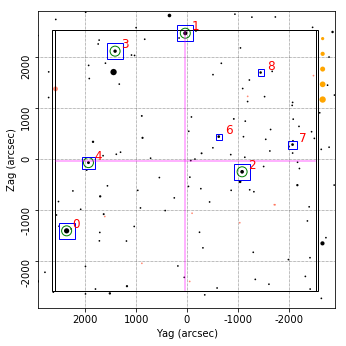

In [150]:
aca19409.acqs.plot()

In [160]:
p_cat = aca19409.acqs['id', 'halfw', 'mag', 'p_acq']
p_cat

id,halfw,mag,p_acq
int32,int64,float32,float64
189417400,160,7.67,0.985
189407848,160,9.04,0.674
189412720,160,9.58,0.919
189409160,160,9.84,0.876
189406216,120,10.27,0.552
189404000,60,10.38,0.512
189403768,80,10.44,0.392
189412392,60,10.55,0.260


In [159]:
ok = aca19409.starcheck_catalog['cat']['halfw'] > 25
s_cat = aca19409.starcheck_catalog['cat'][ok]['id', 'halfw', 'mag', 'p_acq']
s_cat

id,halfw,mag,p_acq
int64,int64,float64,object
189400544,120,9.881,0.72
189409160,160,9.836,0.875
189412720,160,9.61,0.933
189417400,180,7.707,0.985
189406216,120,10.261,0.729
189404000,120,10.401,0.613
189403768,120,10.467,0.55
189412392,120,10.572,0.444


In [161]:
set(s_cat['id']) - set(p_cat['id'])

{189400544}

Star 189400544 mag changed from 9.9 to 10.4 in AGASC 1.7, not used in proseco.  Actual was 10.4!

## Proseco catalog worse: Obsids 21068 (and 21069, 20612) (Dragonfly 44)

The flight catalog used star 261490008 which has MAG_ACA=8.7 and ASPQ1=24 (due to a 10.5 mag star 7.5 arcsec away).  The star was acquired and ID'd by the OBC.  ASPQ1=24 => expected centroid offset of 1.2 arcsec.

Consider a dragonfly-exception to the 3 mag, 30 arcsec keepout rule for acq candidates.  If within 8 arcsec and ASPQ1 < 40 (2.0 arcsec) then allow.  Basically, for acquisition we don't worry about very close spoilers.

In [ ]:
aca21068 = get_aca_catalog(21068)
aca21068.acqs.to_pickle(rootdir=data_dir)
make_report(21068, rootdir=data_dir);

In [15]:
star = agasc.get_star(261490008)

In [16]:
ra, dec = star['RA_PMCORR'], star['DEC_PMCORR']
stars = agasc.get_agasc_cone(ra, dec, radius=0.01)
stars

AGASC_ID,RA,DEC,POS_ERR,POS_CATID,EPOCH,PM_RA,PM_DEC,PM_CATID,PLX,PLX_ERR,PLX_CATID,MAG_ACA,MAG_ACA_ERR,CLASS,MAG,MAG_ERR,MAG_BAND,MAG_CATID,COLOR1,COLOR1_ERR,C1_CATID,COLOR2,COLOR2_ERR,C2_CATID,RSV1,RSV2,RSV3,VAR,VAR_CATID,ASPQ1,ASPQ2,ASPQ3,ACQQ1,ACQQ2,ACQQ3,ACQQ4,ACQQ5,ACQQ6,XREF_ID1,XREF_ID2,XREF_ID3,XREF_ID4,XREF_ID5,RSV4,RSV5,RSV6,RA_PMCORR,DEC_PMCORR
int32,float64,float64,int16,uint8,float32,int16,int16,uint8,int16,int16,uint8,float32,int16,int16,float32,int16,int16,uint8,float32,int16,uint8,float32,int16,uint8,float32,int16,uint8,int16,uint8,int16,int16,int16,int16,int16,int16,int16,int16,int16,int32,int32,int32,int32,int32,int16,int16,int16,float64,float64
261490008,194.67948051,27.11949358,16,5,2000.0,-9999,-9999,0,11,12,3,8.73339,6,0,8.944,2,4,5,0.93245,3,5,1.097,3,5,-9999.0,-9999,0,-9999,0,24,0,74,184,184,184,184,184,160,171,102291,171,1,-9999,-9999,-9999,-9999,194.67948051,27.11949358
261509480,194.68177597,27.1197260097,11,5,2000.0,-9999,5,5,-9999,-9999,0,10.5204,10,0,10.467,6,4,5,0.4692,8,5,0.552,9,5,-9999.0,-9999,0,-9999,0,120,0,74,-201,-201,-201,-201,-201,-201,-9999,-9999,2605,1,-9999,-9999,-9999,-9999,194.68177597,27.1197520448


In [17]:
agasc.sphere_dist(stars[0]['RA_PMCORR'], stars[0]['DEC_PMCORR'], 
                  stars[1]['RA_PMCORR'], stars[1]['DEC_PMCORR']) * 3600

7.4137446969717118

In [18]:
aca21068.starcheck_catalog['cat']

sc_id,obsid,obs_idx,mp_starcat_time,idx,slot,id,idnote,type,sz,p_acq,minmag,mag,maxmag,yang,zang,dim,res,halfw,pass,notes
int64,int64,int64,str21,int64,int64,int64,object,str3,str3,object,object,float64,float64,int64,int64,int64,int64,int64,str4,str2
2127,21068,22,2018:096:06:14:17.430,1,0,2,None,FID,8x8,None,None,7.0,8.0,-774,-850,1,1,25,--,--
2127,21068,22,2018:096:06:14:17.430,2,1,4,None,FID,8x8,None,None,7.0,8.0,2140,1055,1,1,25,--,--
2127,21068,22,2018:096:06:14:17.430,3,2,5,None,FID,8x8,None,None,7.0,8.0,-1828,1053,1,1,25,--,--
2127,21068,22,2018:096:06:14:17.430,4,3,261489768,None,BOT,6x6,0.985,None,9.623,11.125,-2071,-2184,8,1,60,a2g2,--
2127,21068,22,2018:096:06:14:17.430,5,4,261490688,None,BOT,6x6,0.88,None,10.256,11.766,1946,-762,8,1,60,a4g4,--
2127,21068,22,2018:096:06:14:17.430,6,5,261490800,None,BOT,6x6,0.925,None,10.13,11.641,730,-861,8,1,60,a3g3,--
2127,21068,22,2018:096:06:14:17.430,7,6,261492456,None,BOT,6x6,0.985,None,9.698,11.203,-1504,2140,8,1,60,a2g2,--
2127,21068,22,2018:096:06:14:17.430,8,7,261490008,None,BOT,6x6,0.985,None,8.733,10.234,1853,-488,8,1,60,aXgX,--
2127,21068,22,2018:096:06:14:17.430,9,0,261495536,None,ACQ,6x6,0.813,None,10.38,11.891,2060,1327,8,1,60,a4,--


## Proseco catalog worse: Obsid 20532, 21074

Star 1158030184 (mag=10.13) used in SAUSAGE but not in proseco because of a nearby 6400 e-/sec hot pixel.  Otherwise the catalogs are similar.

This star was successfully acquired and ID'd.

Not sure if this passes the "TooNarrow" ACA test, which is not presently implemented in proseco.

In [106]:
obs20532 = get_info(20532, include_aca=True)
aca20532 = obs20532['aca']

In [112]:
p_cat = aca20532.acqs['id', 'halfw', 'mag', 'p_acq']
p_cat.sort('id')
p_cat

id,halfw,mag,p_acq
int32,int64,float32,float64
1157630512,160,10.11,0.770
1157632712,100,8.88,0.946
1157636648,160,9.25,0.957
1158025144,160,10.52,0.293
1158025304,80,10.45,0.608
1158028072,140,10.40,0.516
1158030320,160,9.63,0.919
1158030960,160,8.27,0.985


In [113]:
s_cat = aca20532.starcheck_catalog['cat'][aca20532.starcheck_catalog['cat']['halfw'] > 30]
s_cat = s_cat['id', 'halfw', 'mag', 'p_acq']
s_cat.sort('id')
s_cat

id,halfw,mag,p_acq
int64,int64,float64,object
1157630512,120,10.103,0.848
1157632712,115,8.985,0.985
1157636648,160,9.247,0.973
1158025304,120,10.462,0.605
1158028072,120,10.397,0.661
1158030184,120,10.127,0.773
1158030320,160,9.627,0.935
1158030960,180,8.273,0.985


In [138]:
set(s_cat['id']) - set(p_cat['id'])

{1158030184}

In [118]:
ACACatalogTable(aca20532.acqs.cand_acqs.get_id(1158030184)['imposters'])

col,col0,d_col,d_row,"img [8,8]",img_sum,mag,mag_err,row,row0,yang,zang
float64,int64,float64,float64,float32,float32,float64,float64,float64,int64,float64,float64
-31.53,-36,10.2260625512,-11.7988801982,24.3558 .. 230.443,6827.12,10.04,0.14,392.30,388,-1922.48,-178.21


## Obsid 20295 - required significant fid / acq optimization

Scheduled with two spoiled (yellow) fids.  

Proseco has more stringent criteria (50 arcsec margin vs. 25 arcsec in starcheck).  Proseco found two unspoiled fids.

In [87]:
dat['obsid'][dat['t_opt'] > 1]

20295


In [88]:
obs20295 = get_info(20295, include_aca=True)
aca20295 = obs20295['aca']
aca20295.acqs.bad_stars = None

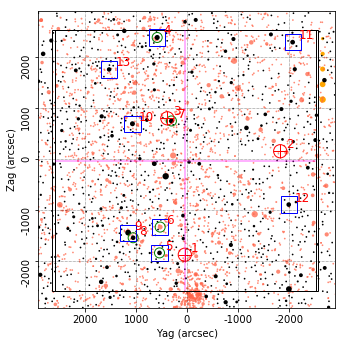

In [89]:
aca20295.plot()

In [90]:
aca20295.dither_acq

<ACABox y=8.0 z=8.0>

In [91]:
aca20295.fids

id,yang,zang,row,col,mag,spoiler_score,idx,slot,type,maxmag,dim,res,halfw,p_acq,sz
int64,float64,float64,float64,float64,float64,int64,int64,int64,str3,float64,int64,int64,int64,int64,str3
3,40.01,-1871.10,-2.67,-371.00,7.00,0,2,0,FID,8.00,1,1,25,0.000,8x8
5,-1826.28,160.17,372.97,36.47,7.00,1,4,1,FID,8.00,1,1,25,0.000,8x8
6,388.59,803.75,-71.49,166.10,7.00,0,5,2,FID,8.00,1,1,25,0.000,8x8


In [92]:
aca20295.fids.cand_fids

id,yang,zang,row,col,mag,spoiler_score,idx,slot
int64,float64,float64,float64,float64,float64,int64,int64,int64
1,922.59,-1737.89,-180.05,-344.10,7.00,4,0,-99
2,-773.20,-1742.03,160.79,-345.35,7.00,1,1,-99
3,40.01,-1871.10,-2.67,-371.00,7.00,0,2,-99
4,2140.23,166.63,-424.51,39.13,7.00,1,3,-99
5,-1826.28,160.17,372.97,36.47,7.00,1,4,-99
6,388.59,803.75,-71.49,166.10,7.00,0,5,-99


## Timing

In [137]:
print(np.mean(dat['t_total']))

0.889176873489


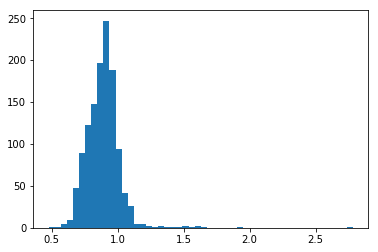

In [31]:
plt.hist(dat['t_total'], bins=50);

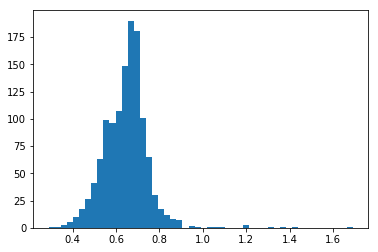

In [32]:
plt.hist(dat['t_acq'], bins=50);

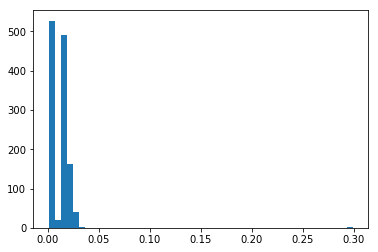

In [33]:
plt.hist(dat['t_fid'], bins=50);

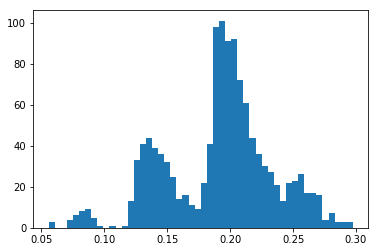

In [34]:
plt.hist(dat['t_guide'], bins=50);

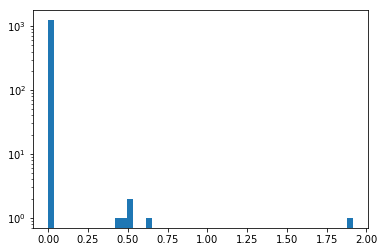

In [35]:
plt.hist(dat['t_opt'], bins=50, log=True);